## Individual Channel Thresholding

I would need to do what I hate, which is pick gates for ideally each image type. 

Ideally, the threshold would be consistent for each marker. I'm not doing any deconvolution or compensation, which might be problematic.

Maybe, compensation and deconvolution are done as a pre-processing step for the image output that I have. 

In [3]:
## Use with Mesmer_pypi conda environment
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.mixture import GaussianMixture
import tifffile
from pathlib import Path
import os
import cv2
import re
import typing
str_or_path = typing.Union[str, os.PathLike]
from deco import synchronized, concurrent

## Functions

In [4]:
def setup_image(image_dir, glob_str= "image.tif", channel_loc= 2, median_ksize= 11, mean_ksize = (11,11)):
    image_name = [file_path for file_path in Path(image_dir).rglob(glob_str)]
    if len(image_name) > 1:
        print(image_dir + " has more than one tif")
    full_img  = tifffile.imread(os.path.join(image_dir, *image_name))
    img = full_img[channel_loc, ...]

    ## Normalize imaging data
    scaled_img = (img - np.mean(img)) / np.std(img)
    norm_img = np.arcsinh(scaled_img)

    return norm_img

def tissue_segmentation_plot(img_dir, img, thresholds, threshold_masks):
    print("Starting plot")
    _, ax = plt.subplots(1,len(thresholds)+1, figsize= (12,6))
    ax[0].imshow(img)
    ax[0].set_title("Marker")
    for i in range(1, len(thresholds)+1):
        ax[i].imshow(threshold_masks[i-1,...], cmap= plt.cm.gray)
        ax[i].set_title(f'Thresh: {round(thresholds[i-1], 1)}')
    plt.suptitle(img_dir) 
    plt.show() 

def run_image_GMM(img, n_gaussians= 4, downsample_divisor= 4):
    ## Downsampling to decrease computation time
    reshaped_img = img.reshape((img.size, 1)).flatten()

    ## Removing the outliers to deal w/ some bright medulla that might've caused some issues. 
        ## I thought about filtering the bottom outliers, but the values are always going to be 0. 
    top_outliers = np.percentile(reshaped_img, [97.5])
    reshaped_img = reshaped_img[(reshaped_img < top_outliers)]
    downsampled_img = np.random.choice(a       = reshaped_img, 
                                       size    = reshaped_img.size // downsample_divisor, 
                                       replace = False)

    ## Add dimension for use w/ GMM
    downsampled_img= downsampled_img[..., np.newaxis]
    gm = GaussianMixture(n_components= n_gaussians)
    gm.fit(downsampled_img)
        ## This is the step that takes a while 

    thresholds = gm.means_.flatten()
    thresholds.sort()

    return thresholds

def make_channel_threshold_masks(img, sorted_thresholds, remove_noise= False, min_spot_area= 50, median_ksize= 11):
    num_thresholds = len(sorted_thresholds)
    threshold_masks = np.zeros((num_thresholds, img.shape[0], img.shape[1]))

    for i in range(0, num_thresholds):
        threshold  = sorted_thresholds[i]
        binary_img = img > threshold
        binary_img = binary_img * np.uint8(1)     

        if remove_noise: 
            ## Small hole filling to capture missing nuclei
            contour, hier = cv2.findContours(binary_img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contour:
                cv2.drawContours(binary_img,[cnt],0,255,-1)

            ## Removing small noise
            binary_img = cv2.medianBlur(binary_img, median_ksize)
            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_img)

            filtered_img = np.zeros_like(binary_img)
            for label in range(1, num_labels):
                area = stats[label, cv2.CC_STAT_AREA]
                if area >= min_spot_area:
                    filtered_img[labels == label] = 255
        else:
            filtered_img = binary_img

        threshold_masks[i,...] = filtered_img
    return threshold_masks

@concurrent
def threshold_channel(img_dir, thresholds, channel_loc, out_name= "", glob_str= "reordered_image.ome.tif", save_mask= False, remove_noise= False, is_adaptive= False, show_plots= True) -> None:
    print("Starting " + img_dir + "\n")

    ## Take stain and apply thresholds
    img = setup_image(image_dir= img_dir, glob_str= glob_str,  channel_loc= channel_loc)
    
    if is_adaptive:
        threshold_masks = make_adaptive_binary_gate(img_arr = img) 
        show_plots = False
    else: 
        threshold_masks = make_channel_threshold_masks(img= img, sorted_thresholds= thresholds, remove_noise = remove_noise)
    threshold_masks = threshold_masks.astype("uint8") 

    if show_plots: 
        tissue_segmentation_plot(
            img_dir         = img_dir, 
            img             = img,
            thresholds      = thresholds, 
            threshold_masks = threshold_masks
        )

    if save_mask:
        assert min(threshold_masks.shape) == 1, "There are multiple threshold masks. Make sure there is only one threshold in the thresholds argument."
        assert len(out_name) > 0, "Set out_name to save image."
        tifffile.imwrite(os.path.join(img_dir, out_name), threshold_masks.squeeze())

    return None
    

@synchronized
def parallelize_channel_thresholding(img_dirs, thresholds, channel_loc, is_adaptive, save_mask, out_name= "", glob_str= "reordered_image.ome.tif", remove_noise= False, show_plots= True):
    ## Use this function to speed up plotting of whole lobe masks and medulla masks
    ## I'll visually inspect the results to pick the best thresholds
    for img_dir in img_dirs:
        threshold_channel(
            img_dir      = img_dir, 
            thresholds   = thresholds, 
            channel_loc  = channel_loc, 
            glob_str     = glob_str,
            save_mask    = save_mask,
            out_name     = out_name, 
            remove_noise = remove_noise,
            is_adaptive  = is_adaptive,
            show_plots   = show_plots
        )

def overlay_mask(img_dir, image_name, mask_name, out_name) -> None:
    img= tifffile.imread(os.path.join(img_dir, image_name))
    mask = tifffile.imread(os.path.join(img_dir, mask_name))
    mask = mask[np.newaxis,...]

    img_w_mask= np.concatenate((img, mask))

    tifffile.imwrite(os.path.join(img_dir, out_name), img_w_mask)

    return None

def make_adaptive_binary_gate(img_arr, median_kernel_size= 5, adaptive_subtraction= 1, adaptive_kernel_size= 5, min_spot_area= 0):
    ## OpenCV documentation recommended blurring prior to adaptive thresholding
    img_arr = img_arr.astype("uint8")
    blurred = img_arr
    blurred = cv2.medianBlur(img_arr, median_kernel_size)

    threshold_img = cv2.adaptiveThreshold(blurred, 
                                          255, 
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C, ## I think Gaussian looks significantly better than mean for cortical images.
                                          cv2.THRESH_BINARY, 
                                          adaptive_kernel_size, 
                                          adaptive_subtraction)
    filtered_img = threshold_img[np.newaxis, ...]



    # ## Small hole filling to capture missing nuclei
    # contour, hier = cv2.findContours(threshold_img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    # for cnt in contour:
    #     cv2.drawContours(threshold_img,[cnt],0,255,-1)

    # ## Filtering to remove salt and pepper noise
    # threshold_img = cv2.medianBlur(threshold_img, median_kernel_size)

    # ## Removing specks
    # num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(threshold_img)
    # filtered_img = np.zeros_like(threshold_img)
    # for label in range(1, num_labels):
    #     area = stats[label, cv2.CC_STAT_AREA]
    #     if area >= min_spot_area:
    #         filtered_img[labels == label] = 255

    # filtered_img = filtered_img[np.newaxis, ...]
    
    return filtered_img


def segment_image_using_mask(img_dir, image_name= "reordered_image.ome.tif", mask_name= "DC_mask_adaptive.tif", out_name= "DC_image.ome.tif") -> None:

    img = tifffile.imread(os.path.join(img_dir, image_name))
    DC_binary_mask = tifffile.imread(os.path.join(img_dir, mask_name))

    DC_sub_img = img * DC_binary_mask

    tifffile.imwrite(os.path.join(img_dir, out_name), DC_sub_img)

    return None 

# CD11c Thresholding

Everything will be derived from a CD11c mask (or CD63 in the case of macrophages)

In [5]:
raw_dir = "/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10"
img_dirs = [os.path.join(raw_dir, img_dir) for img_dir in os.listdir(raw_dir) if re.search("_[A-D]$", img_dir)]

Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_Sirpa_CD63_MerTK_B
Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_B
Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD63_CD11c_XCR1_A
Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_A
Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD207_CD11c_XCR1_C
Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD63_CD11c_Sirpa_C
Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD63_CD11c_Sirpa_D
Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_Sirpa_CD11c_CD14_C
Starting /stor/scratch/Ehrlich/Users/John/histocytome

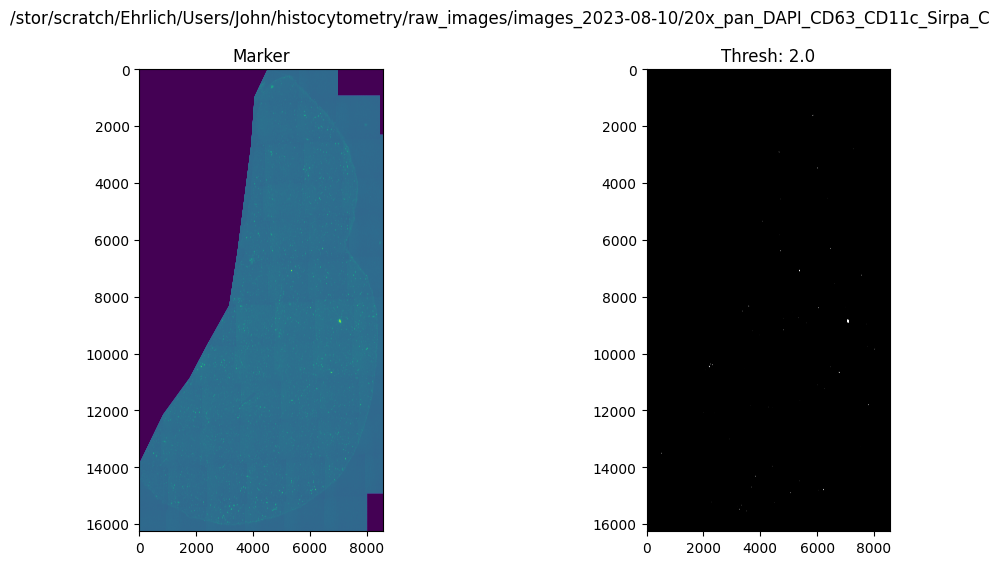

Starting plot


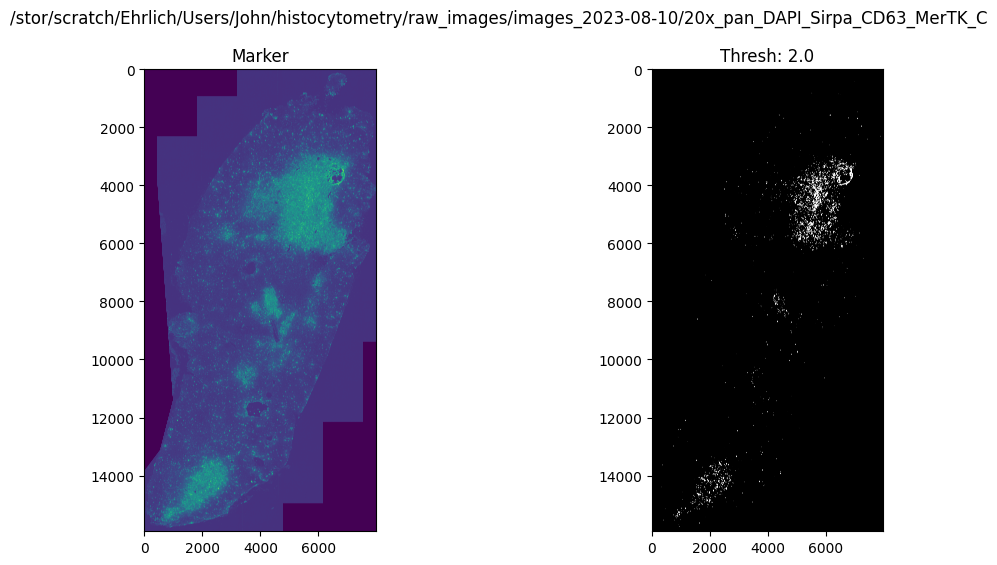

Starting plot
Starting plot


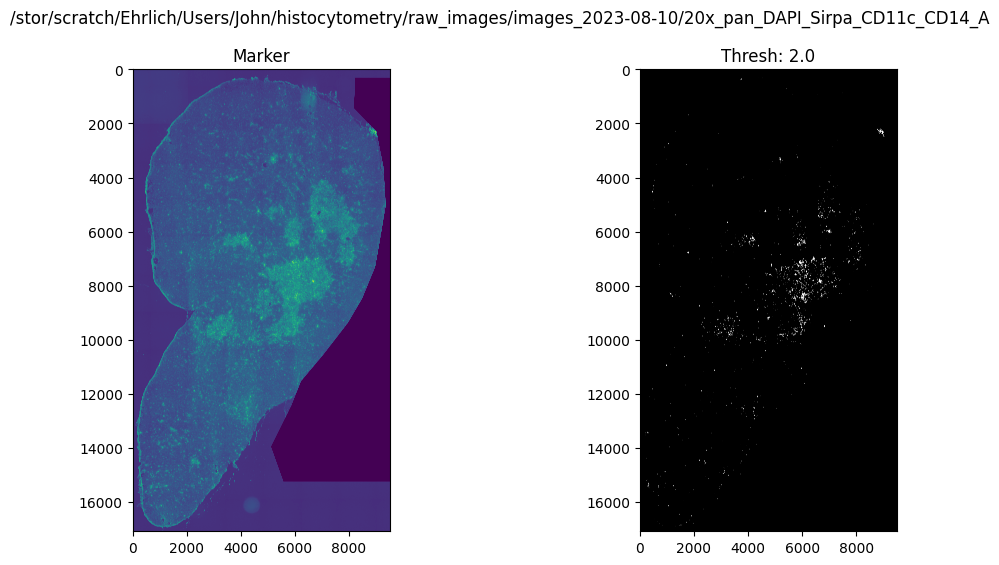

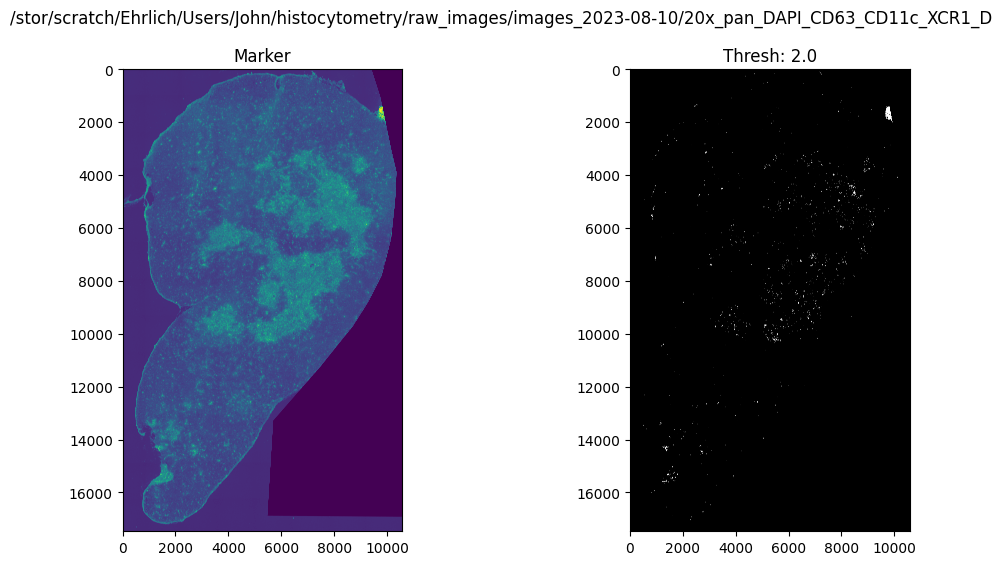

Starting plot


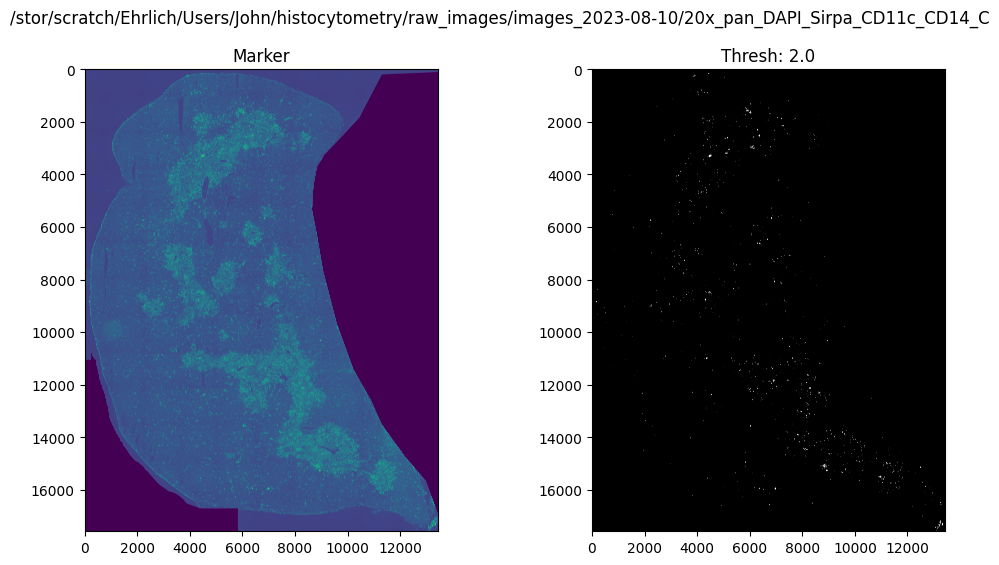

Starting plot


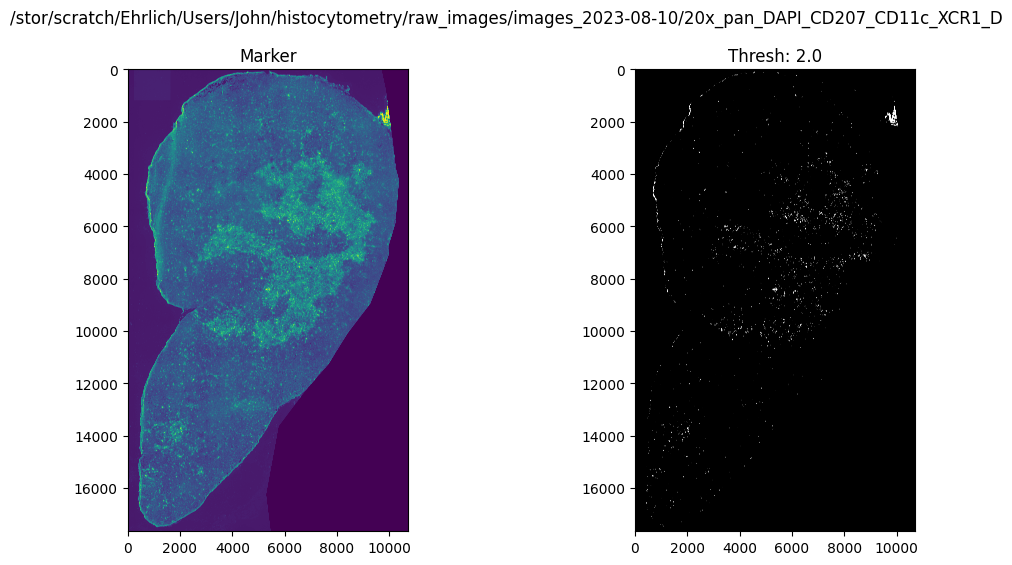

Starting plot


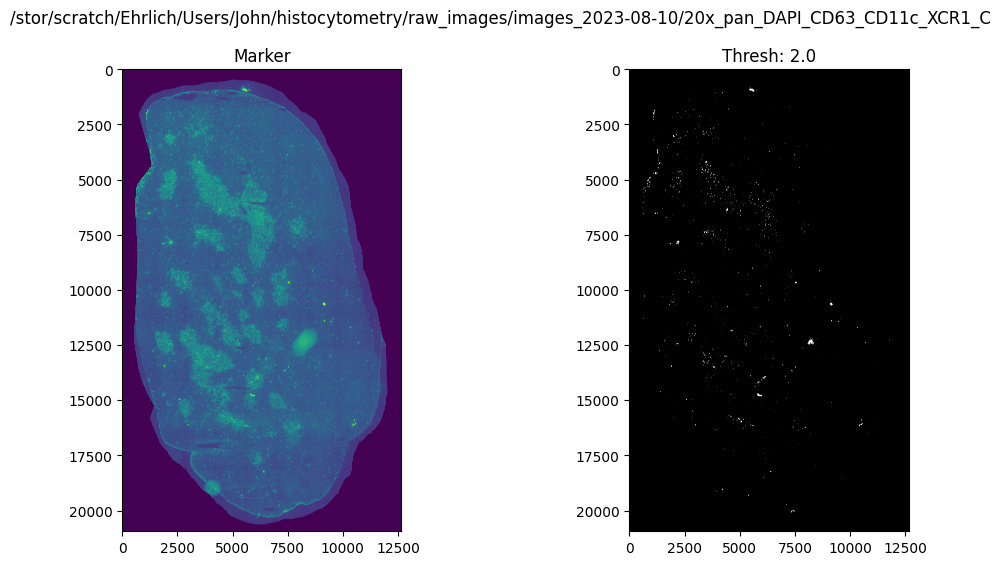

Starting plot


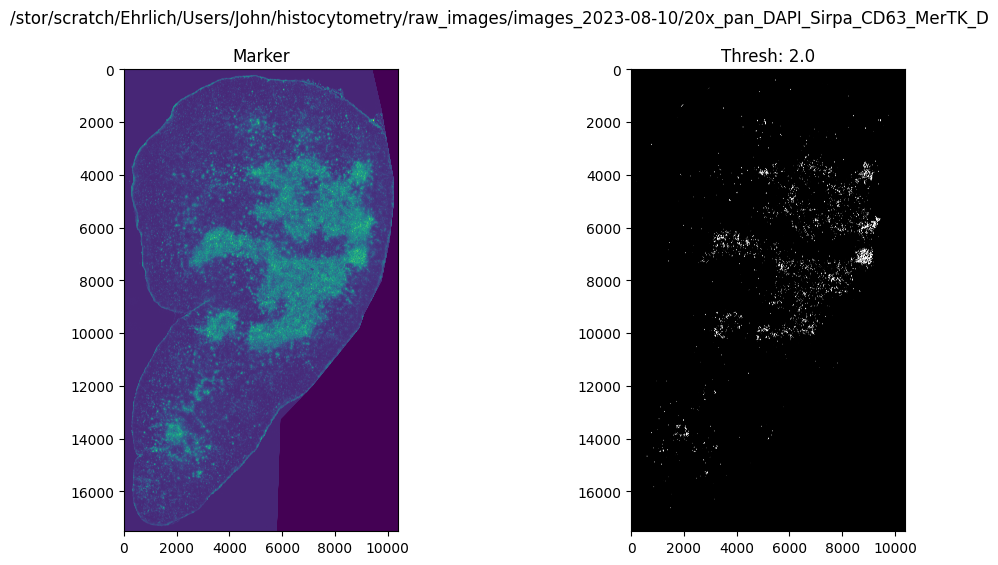

Starting plot


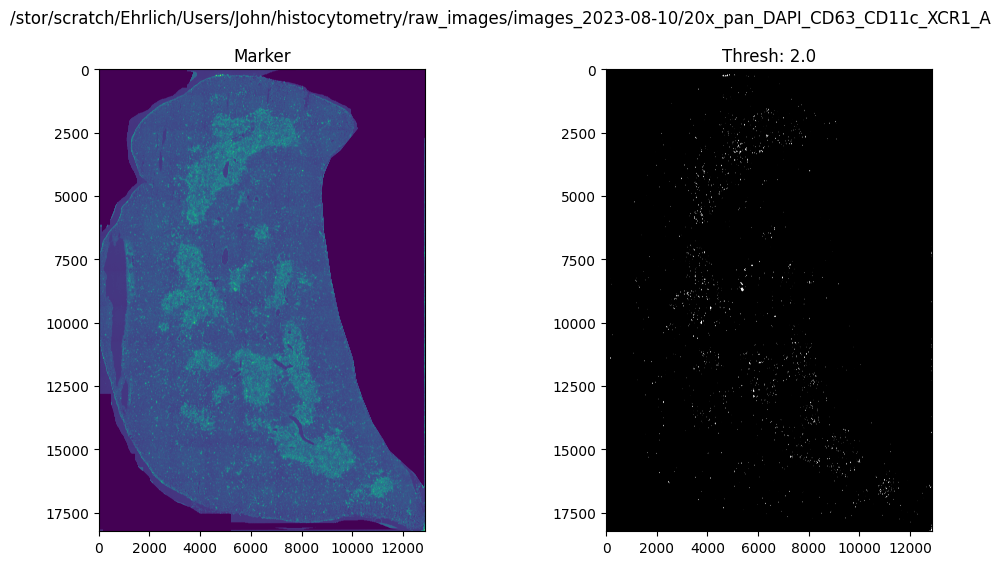

Starting plot


KeyboardInterrupt: 

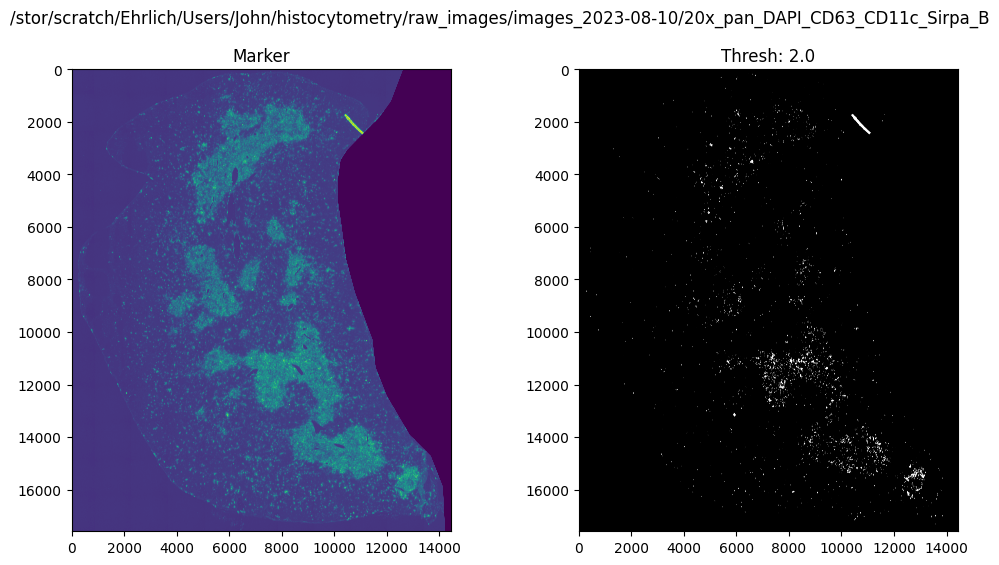

Starting plot


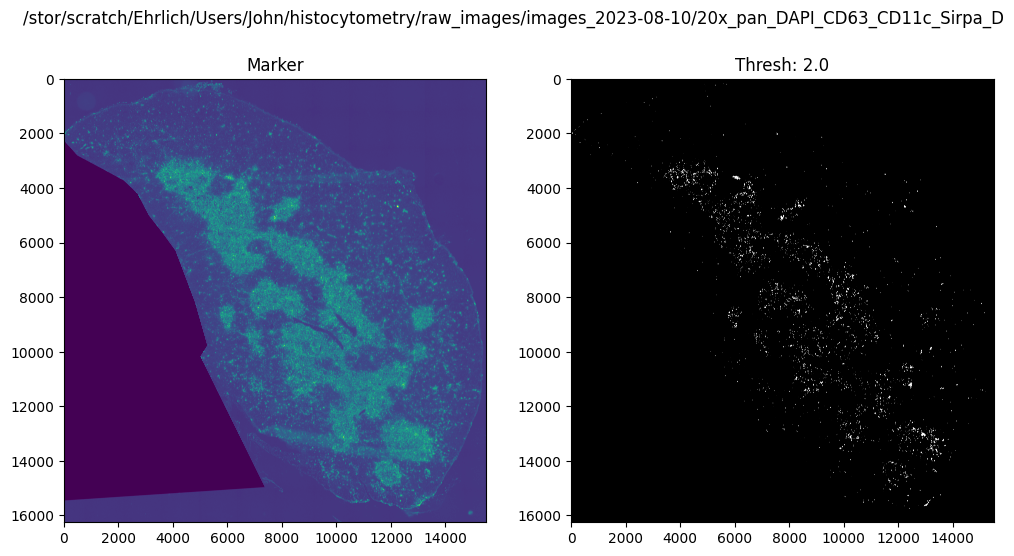

Starting plot
Starting plot


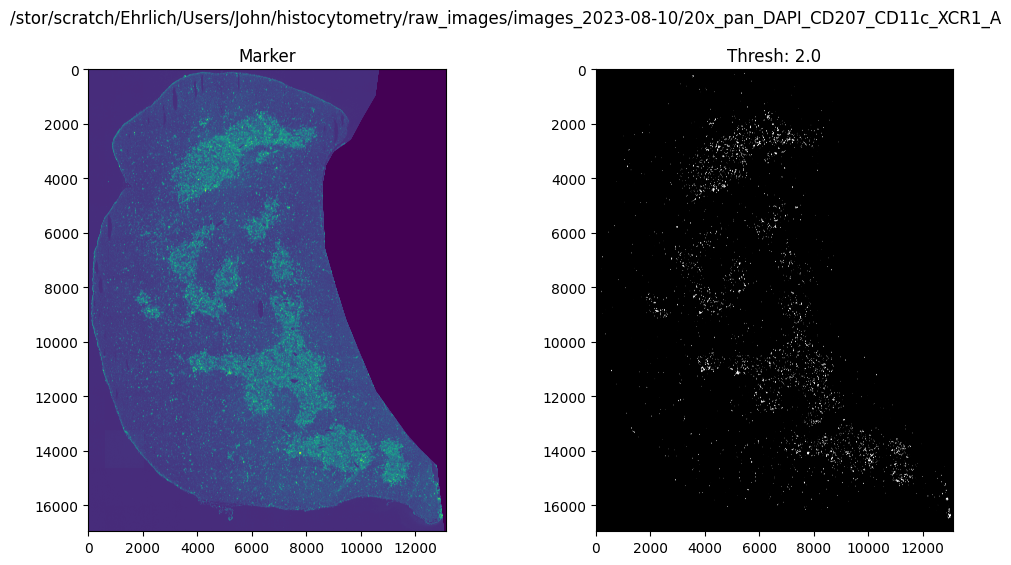

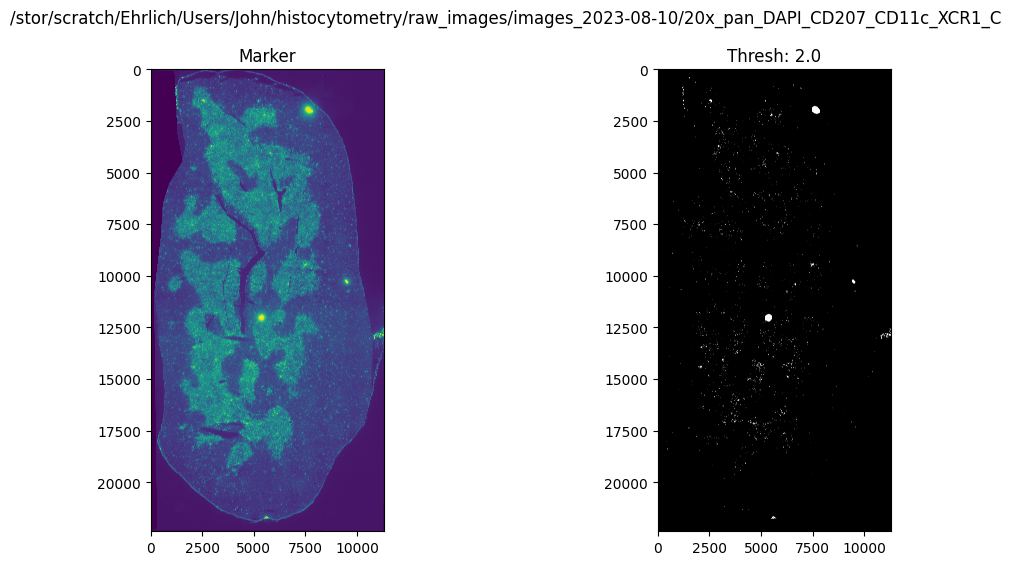

Starting plot
Starting plot


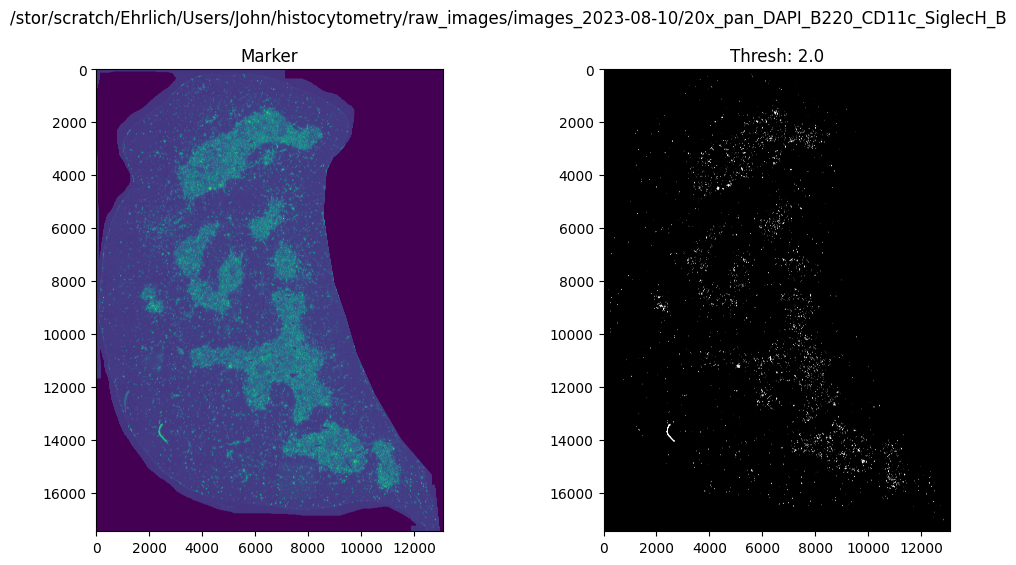

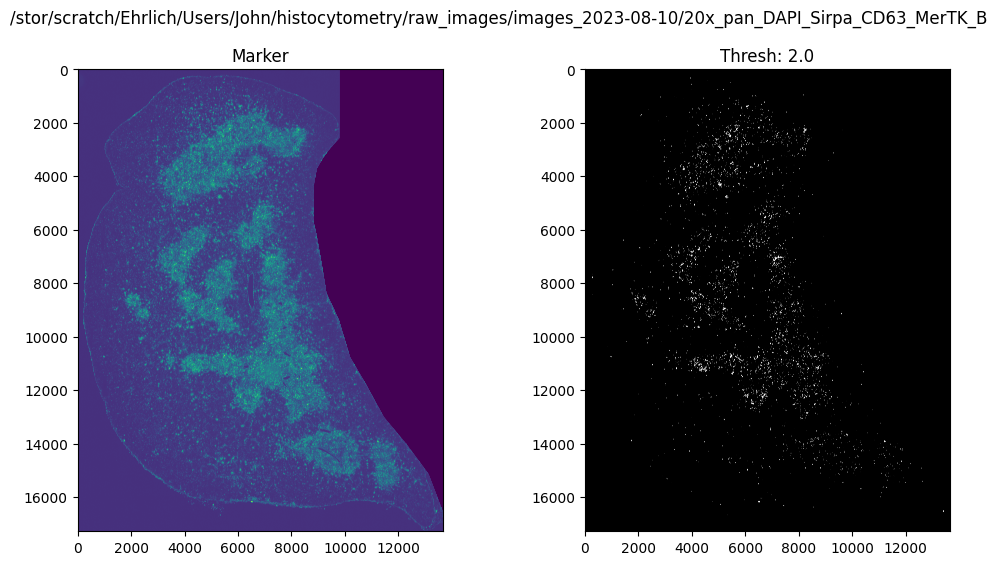

In [124]:
parallelize_channel_thresholding(
    img_dirs     = img_dirs,
    thresholds   = np.arange(1.5, 1.75, 0.25),
    channel_loc  = 2,
    save_mask    = True,
    out_name     = "DC_mask.tif",
    is_adaptive  = False,
    remove_noise = True,
    show_plots   = False
)

## I have to crop out CD11c bright spots and capsular stain. 
## The adaptive thresholding doesn't work. 
## I've scaled the images to make them somewhat comparable. 
## The non-adaptive thresholding takes ~20 minutes, but area filtering with a median blur removes specks. 



In [7]:
## Overlay DC mask
for img_dir in img_dirs: 
    overlay_mask(  
        img_dir    = img_dir, 
        image_name = "reordered_image.ome.tif", 
        mask_name  = "DC_mask.tif", 
        out_name   = "img_w_DC_mask.ome.tif"
    )
    print(img_dir)

/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_Sirpa_CD63_MerTK_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_B
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD63_CD11c_XCR1_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD63_CD11c_Sirpa_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD207_CD11c_XCR1_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_Sirpa_CD63_MerTK_A
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_Sirpa_CD11c_CD14_C
/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_CD63_CD11c_Sirpa_D
/stor/scratch/Eh

In [8]:
## Segmenting images to include only DCs (as defined by the adaptive CD11c or CD63 mask)
for img_dir in img_dirs: 
    segment_image_using_mask(
        img_dir    = img_dir, 
        image_name = "reordered_image.ome.tif",
        mask_name  = "DC_mask.tif", 
        out_name   = "DC_image.ome.tif"
    )
    print(img_dir)

## DAPI mask from CD11c mask 

I think I can draw the circles using draw contours, then filter by area to only keep the real nuclei and remove the partial segmentation.

After that, I will do watershed segmentation with DAPI as the seed point. 

In [ ]:
##-------------------------
# General watershed outline
##-------------------------
## My first step will be to see how the DAPI signal actually looks following CD11c masking. 

img_dir = os.path.join(raw_dir, "20x_pan_DAPI_B220_CD11c_SiglecH_A")
image_name= "DC_image.ome.tif"
channel_loc= 0

def DAPI_watershed(img_dir, image_name, channel_loc= 0):
    img = tifffile.imread(os.path.join(img_dir, image_name))
    DAPI= img[channel_loc, ...]

    ## Convert DAPI to binary image
    ret, thresh = cv.threshold(DAPI,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

    ## Remove noise 
    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel)
    
    ## Make nuclei smaller and non-overlapping 

    # sure background area
    sure_bg = cv.dilate(opening,kernel)

    # Finding sure foreground area
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
    ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg,sure_fg)

    ## Plotting images for validation
    _, ax = plt.subplots(1, 3, figsize= (12,6))
    ax[0].imshow(thresh)
    ax[0].set_title("OTSU_Binary")
    ax[1].imshow(sure_bg)
    ax[1].set_title("Sure Bg")
    ax[2].imshow(sure_fg)
    ax[2].set_title("Sure fg")
    plt.suptitle(img_dir) 
    plt.show() 
    

    ## Removing DAPI that is too small 
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(sure_fg)

    filtered_img = np.zeros_like(sure_fg)
    for label in range(1, num_labels):
        area = stats[label, cv2.CC_STAT_AREA]
        if area >= min_spot_area:
            filtered_img[labels == label] = 255

    labels = labels+1
    markers[unknown == 255] = 0

    markers = cv.watershed(filtered_img, labels)
    img[markers == -1] = [255,0,0]
        ## using DAPI as seed points for DC_mask 
    ## Using DAPI as seed points within DC mask
    ## Isolate DAPI channel from DC_subset
    

In [37]:
img_dir = os.path.join(raw_dir, "20x_pan_DAPI_B220_CD11c_SiglecH_B")
image_name= "DC_image.ome.tif"
channel_loc= 0

img = tifffile.imread(os.path.join(img_dir, image_name))
DAPI= img[channel_loc, ...]

In [38]:
## Convert DAPI to binary image
top_1_percent = np.percentile(DAPI.flatten(), 99.9)
print(top_1_percent)
print(np.max(DAPI))
binary_img = DAPI > top_1_percent
    ## I think swapping this to an adaptive thresholding with sufficient subtraction should yield one nucleus with median blur and morphology.
    ## I also need to work on thymus segmentation. 
    
binary_img = binary_img[np.newaxis,...]
top_1_img = np.concatenate((img, binary_img))
tifffile.imwrite(os.path.join(img_dir, "top_1_img.ome.tif"), top_1_img)

246.0
254


In [13]:
## Convert DAPI to binary image
top_1_percent = np.percentile(DAPI.flatten(), 0.99)
binary_img = DAPI > top_1_percent

## Remove noise 
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel)
    
## Make nuclei smaller and non-overlapping 

# sure background area
sure_bg = cv2.dilate(opening,kernel)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

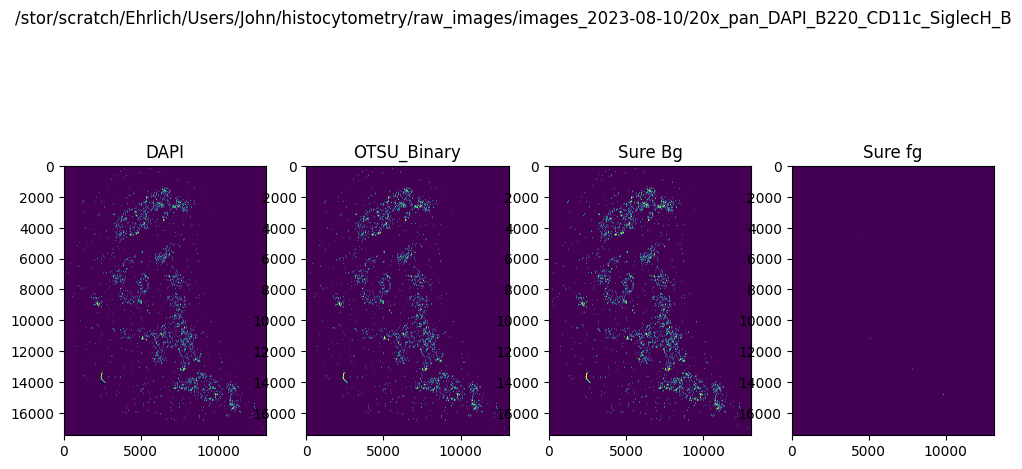

In [14]:
## Plotting images for validation
_, ax = plt.subplots(1, 4, figsize= (12,6))
ax[0].imshow(DAPI)
ax[0].set_title("DAPI")
ax[1].imshow(thresh)
ax[1].set_title("OTSU_Binary")
ax[2].imshow(sure_bg)
ax[2].set_title("Sure Bg")
ax[3].imshow(sure_fg)
ax[3].set_title("Sure fg")
plt.suptitle(img_dir) 
plt.show() 

In [22]:
## Removing DAPI that is too small 
min_spot_area= 100
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(sure_fg)

filtered_img = np.zeros_like(sure_fg)
for label in range(1, num_labels):
    area = stats[label, cv2.CC_STAT_AREA]
    if area >= min_spot_area:
        filtered_img[labels == label] = 255

labels = labels+1
labels[unknown == 255] = 0
labels = labels.astype("uint8")

In [29]:
print(labels)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [23]:
print(labels.dtype)
print(filtered_img.dtype)

uint8
uint8


In [24]:
labels = cv2.watershed(filtered_img, labels)
img[labels == -1] = [255,0,0]

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/segmentation.cpp:161: error: (-215:Assertion failed) src.type() == CV_8UC3 && dst.type() == CV_32SC1 in function 'watershed'


In [ ]:
_, ax = plt.subplots(1, 2, figsize= (12,6))
ax[0].imshow(DAPI)
ax[0].set_title("DAPI")
ax[1].imshow(img)
ax[1].set_title("watershed_img")
plt.suptitle(img_dir) 
plt.show() 

## Thresholding Evaluation

### aDC2_Sirpa/cDC2

In [36]:
raw_dir = "/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10"
exp_dirs = [os.path.join(raw_dir, img_dir) for img_dir in os.listdir(raw_dir) if re.search("Sirpa_(A,B,D)$", img_dir)]
    ## removing Sirpa_C because it's awful.
n_channels = np.arange(1,4,1)

for i in n_channels:
    print(f"Channel {i}")
    parallelize_channel_thresholding(
        img_dirs = exp_dirs, 
        thresholds= np.arange(-1, 5, 1),
        channel_loc = i, 
        save_mask = False
    )

## The intensities differ pretty significantly between 

Channel 1
Channel 2
Channel 3


### pDCs

Channel 1
Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_A
Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_B
Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_C



Starting plot
Starting plot
Starting plot


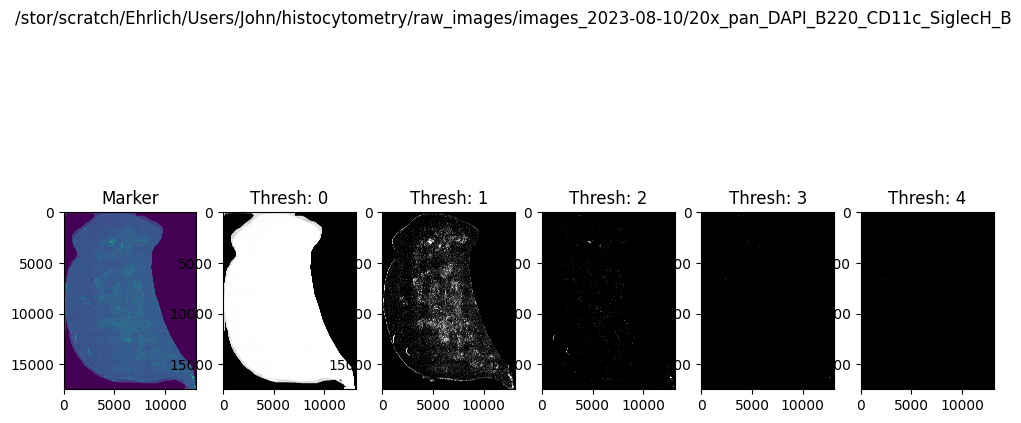

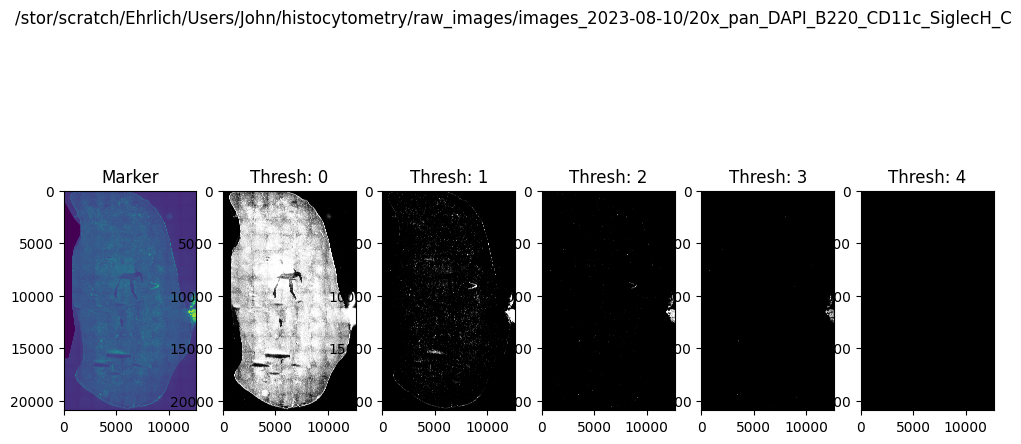

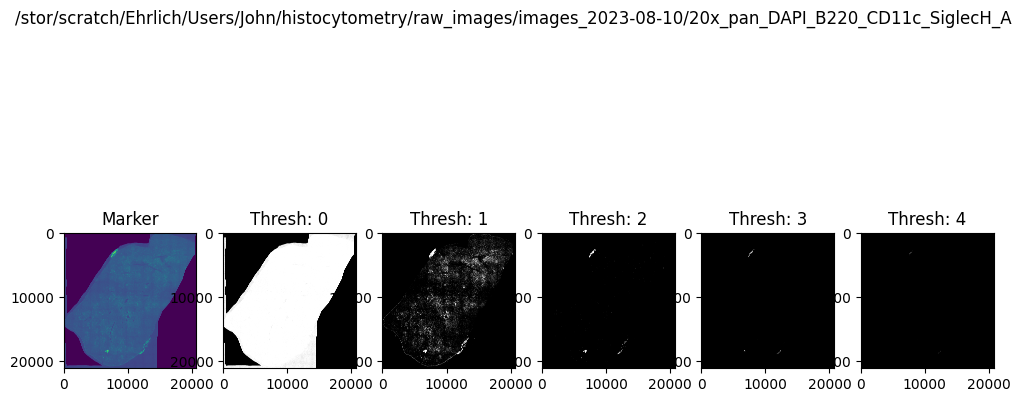

Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_B
Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_A
Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_C



Channel 2
Starting plot
Starting plot
Starting plot


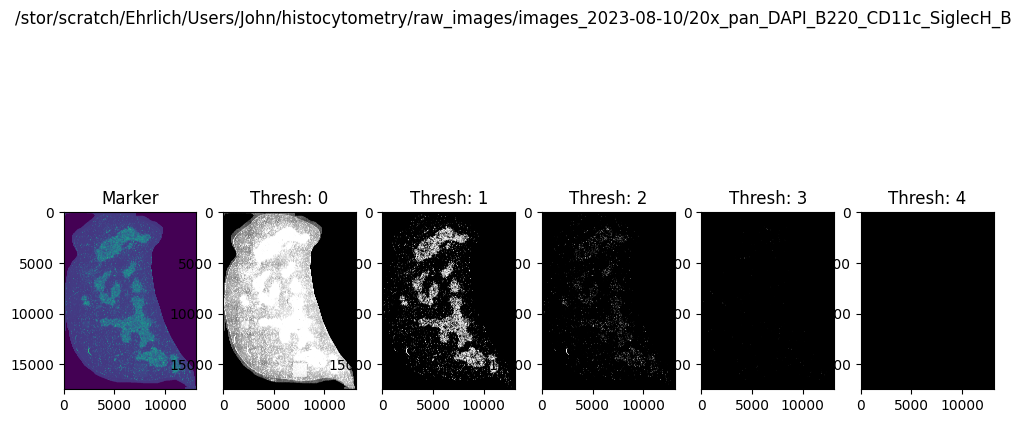

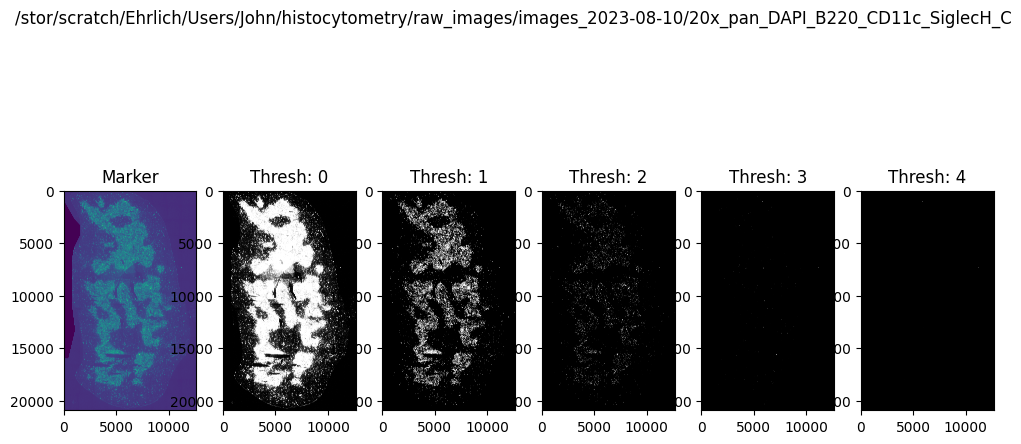

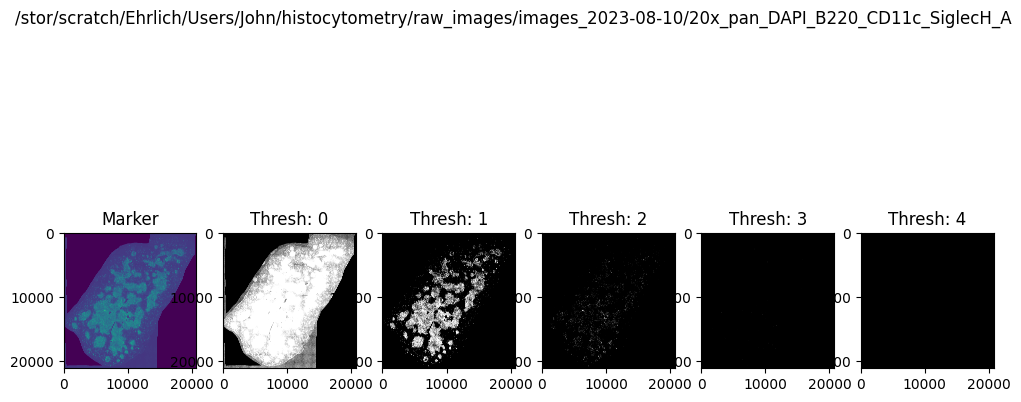

Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_B
Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_C
Starting /stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_A



Channel 3
Starting plot
Starting plot
Starting plot


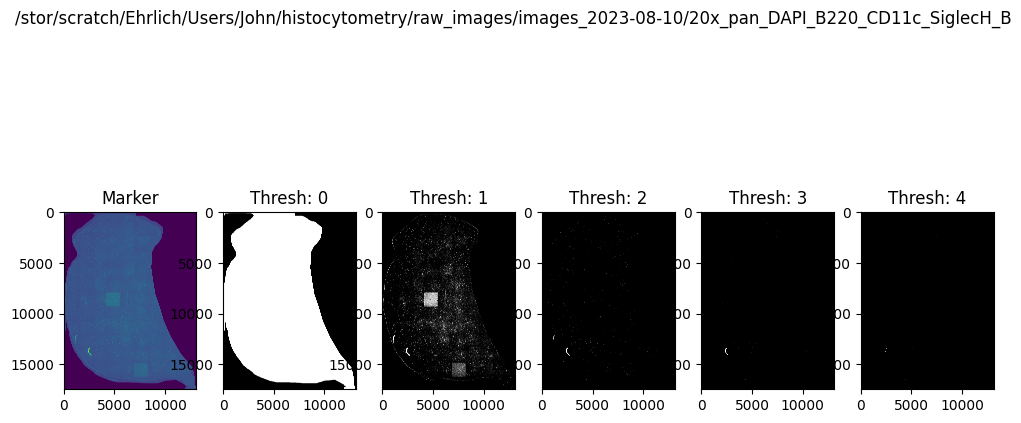

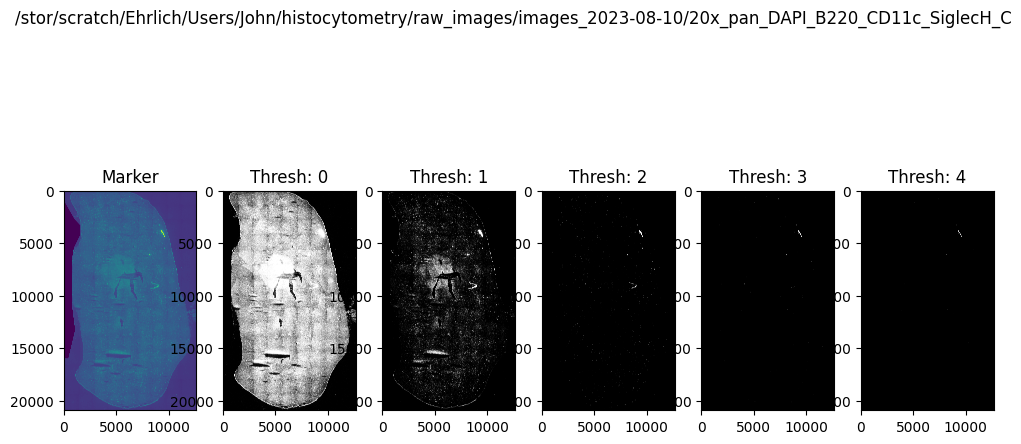

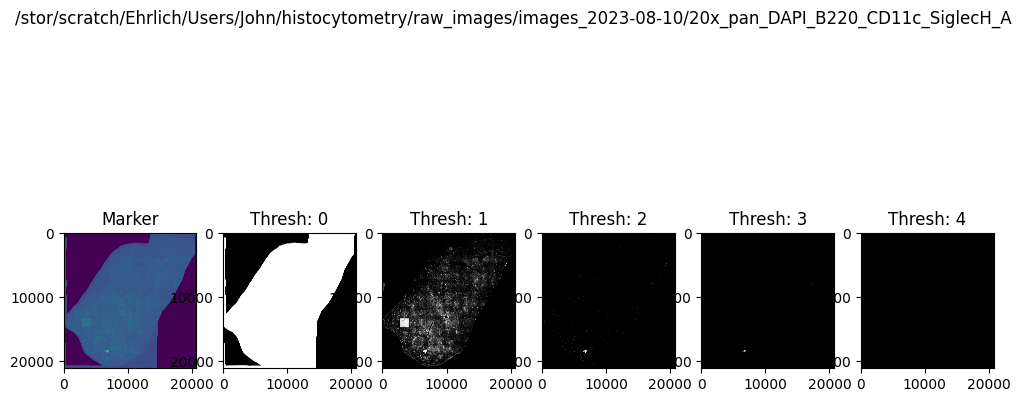

In [37]:
raw_dir = "/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10"
exp_dirs = [os.path.join(raw_dir, img_dir) for img_dir in os.listdir(raw_dir) if re.search("SiglecH_[A-D]$", img_dir)]
n_channels = np.arange(1,4,1)

for i in n_channels:
    print(f"Channel {i}")
    parallelize_channel_thresholding(
        img_dirs = exp_dirs, 
        thresholds= np.arange(0, 5, 1),
        channel_loc = i, 
        save_mask = False
    )

## If I haven't normalized values across images, I probably shouldn't try to compare them. 
## I could do scaling by the markers and then arcsinh to get everything on the same scale. 

## This looks much more promising. 
## I wonder if I should be doing this kind of normalization across the previous image analysis steps. 
    ## The answer is definitely, yes, but I loath the thought of re-running the medulla and cortex segmentation. 

### monoDC2s

In [ ]:
raw_dir = "/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10"
exp_dirs = [os.path.join(raw_dir, img_dir) for img_dir in os.listdir(raw_dir) if re.search("CD14_[A-D]$", img_dir)]
n_channels = np.arange(1,4,1)

for i in n_channels:
    print(f"Channel {i}")
    parallelize_channel_thresholding(
        img_dirs = exp_dirs, 
        thresholds= np.arange(10, 35, 5),
        channel_loc = i, 
        save_mask = False
    )

### Macrophages

In [ ]:
raw_dir = "/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10"
exp_dirs = [os.path.join(raw_dir, img_dir) for img_dir in os.listdir(raw_dir) if re.search("MerTK_[A-D]$", img_dir)]
n_channels = np.arange(1,4,1)

for i in n_channels:
    print(f"Channel {i}")
    parallelize_channel_thresholding(
        img_dirs = exp_dirs, 
        thresholds= np.arange(10, 35, 5),
        channel_loc = i, 
        save_mask = False
    )

### aDC1/aDC2_XCR1

In [ ]:
raw_dir = "/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10"
exp_dirs = [os.path.join(raw_dir, img_dir) for img_dir in os.listdir(raw_dir) if re.search("XCR1_[A-D]$", img_dir)]
n_channels = np.arange(1,4,1)

for i in n_channels:
    print(f"Channel {i}")
    parallelize_channel_thresholding(
        img_dirs = exp_dirs, 
        thresholds= np.arange(10, 35, 5),
        channel_loc = i, 
        save_mask = False
    )

# Old Code

In [27]:
## Maybe it would be helpful to do some gating to see what the data that we're actually dealing with looks like. 
img_dir = "/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/images_2023-08-10/20x_pan_DAPI_B220_CD11c_SiglecH_A"
img = tifffile.imread(os.path.join(img_dir, "reordered_image.ome.tif"))
# whole_lobe_mask = tifffile.imread(os.path.join(img_dir, "whole_lobe_mask.tif"))

# B220    = img[1,whole_lobe_mask].flatten()
# CD11c   = img[2,whole_lobe_mask].flatten()
# SiglecH = img[3,whole_lobe_mask].flatten()
    ## The point of this code was to filter out the non-biological values before flattening into a 1D array.
    ## I'm sure this is possible, but this is wrong, and it's going to take too long regardless.
# print(B220.size/1e6)

## Normalize imaging data
img= img[1,...]
scaled_img = (img - np.mean(img)) / np.std(img)
norm_img = np.arcsinh(scaled_img)

print((np.min(norm_img), np.max(norm_img)))

(-0.9441250084269859, 4.528197464380236)


In [32]:
print(scaled_img.dtype)

float64


In [31]:
med_blur = cv2.medianBlur(scaled_img, 11)  

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/median_blur.simd.hpp:880: error: (-215:Assertion failed) src.depth() == CV_8U && (cn == 1 || cn == 3 || cn == 4) in function 'medianBlur'


In [18]:
# Plot the points
_, ax = plt.subplots(1,3, figsize= (12,6))
ax[0].scatter(B220, CD11c)
ax[0].contour(B220, CD11c, 
ax[0].xlabel('B220')
ax[0].ylabel('CD11c')

ax[0].scatter(B220, SiglecH)
ax[0].xlabel('B220')
ax[0].ylabel('SiglecH')

ax[0].scatter(SiglecH, CD11c)
ax[0].xlabel('SiglecH')
ax[0].ylabel('CD11c')

plt.suptitle(img_dir)
plt.show()


plt.scatter(B220, CD11c)
plt.xlabel('B220')
plt.ylabel('CD11c')
plt.title('pDC')
plt.grid(True)
plt.show()